# Basic demo of training GNN on boid model.
All the scripts are in **scripts.gnn.gnn** and **scripts.gnn.gnn_definition**.
The scripts build barebone GNN network architecture, handling of discrete data. 
The notebook illustrates training and testing and demos of single-frame prediction.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import combinations
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as functional
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from collab_env.data.file_utils import expand_path, get_project_root

In [3]:
from collab_env.gnn.gnn import get_adjcency_from_debug, plot_log_loss, train_rules_gnn
from collab_env.gnn.gnn_definition import GNN, Lazy

### 1. Load data

In [4]:
dataset = torch.load(
    expand_path("simulated_data/boid_single_species_short.pt", get_project_root()),
    weights_only=False,
)
species_configs = torch.load(
    expand_path(
        "simulated_data/boid_single_species_short_config.pt", get_project_root()
    ),
    weights_only=False,
)

In [5]:
# split data into training set and test set
test_size = int(len(dataset) / 2)
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size], generator=torch.Generator().manual_seed(2025)
)

In [6]:
# create mini-batches
batch_size = 1
# right now we assume the batch_size = 1, because our real dataset are of different lengths.
# But we can expand to minibatches - except fpr a few specific functions, every function is written with minibatches in mind.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

batch = list(iter(train_loader))[0]
pos, species = batch

print("made", str(len(list(train_loader))), "batches, each of size", str(batch_size))  #
print(
    "Batch position:", pos.shape
)  # [Batch size, Number of boids, coordinates (x,y pos)= 2]
print("Species labels:", species.shape)  # [B, N]
print("\n")

made 25 batches, each of size 1
Batch position: torch.Size([1, 10, 20, 2])
Species labels: torch.Size([1, 20])




/Users/dima/git/collab-environment/.venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### 2. Train GNN and our lazyGNN
The lazy model only outputs a zero acceleration at all frames.

In [7]:
# Specify various model configurations
models: dict[str, dict[str, Any]] = {}

models["vpluspplus_a"] = {}
models["vpluspplus_a"][
    "node_feature_function"
] = "vel_plus_pos_plus"  # features are velocity(t-2), velocity(t-1), velocity(t)
models["vpluspplus_a"]["node_prediction"] = "acc"  # predict model acceleration
models["vpluspplus_a"]["prediction_integration"] = "Euler"  # predict model acceleration
models["vpluspplus_a"]["input_differentiation"] = "finite"
models["vpluspplus_a"]["in_node_dim"] = 6 + 6 + 6 + 1
models["vpluspplus_a"]["start_frame"] = 3
models["vpluspplus_a"]["lr"] = 1e-4

models["lazy"] = {}
models["lazy"]["node_feature_function"] = None
models["lazy"]["node_prediction"] = None
models["lazy"]["prediction_integration"] = "Euler"  # predict model acceleration
models["lazy"]["input_differentiation"] = "finite"
models["lazy"]["in_node_dim"] = 3
models["lazy"]["start_frame"] = None
models["lazy"]["lr"] = None

In [8]:
for m in models:

    (
        node_feature_function,
        node_prediction,
        input_differentiation,
        prediction_integration,
        in_node_dim,
        start_frame,
        lr,
    ) = (
        models[m]["node_feature_function"],
        models[m]["node_prediction"],
        models[m]["input_differentiation"],
        models[m]["prediction_integration"],
        models[m]["in_node_dim"],
        models[m]["start_frame"],
        models[m]["lr"],
    )
    gnn_model: torch.nn.Module | None = None
    # initialize models
    if m == "lazy":
        training = False
        lr = None
        gnn_model = Lazy(
            model_name=m,
            input_differentiation=input_differentiation,
            prediction_integration=prediction_integration,
            heads=1,
            in_node_dim=in_node_dim,
        )
        epoch_num = 1  # number of training epochs

    else:
        training = True
        gnn_model = GNN(
            model_name=m,
            node_feature_function=node_feature_function,
            node_prediction=node_prediction,
            input_differentiation=input_differentiation,
            prediction_integration=prediction_integration,
            start_frame=start_frame,
            heads=1,
            in_node_dim=in_node_dim,
        )

        epoch_num = 3  # number of training epochs

    visual_range = (
        0.5  # visual range, give a large number, ask the network to prune for us!
    )

    # train models
    (models[m]["train_losses"], models[m]["model"], models[m]["debug_result"]) = (
        train_rules_gnn(
            gnn_model,
            train_loader,
            visual_range=visual_range,
            epochs=epoch_num,
            lr=lr,
            training=training,
            species_dim=len(torch.unique(species)),
            device=None,
        )
    )

    models[m]["W_input"], models[m]["W_output"] = get_adjcency_from_debug(
        models[m]["debug_result"], train_loader, visual_range
    )

/Users/dima/git/collab-environment/collab_env/gnn/gnn.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos = torch.tensor(pos)
/Users/dima/git/collab-environment/collab_env/gnn/gnn.py:357: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vel = torch.tensor(vel)
/Users/dima/git/collab-environment/collab_env/gnn/gnn.py:358: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  acc = torch.tensor(acc)
/Users/dima/git/collab-environment/collab_env/gnn/gnn.py:406: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

epoch 0


batch 0


batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


Epoch 000 | Train: 0.0060
epoch 1


batch 0


batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


epoch 2


batch 0


batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


finished one epoch
epoch 0


batch 0


batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


In [9]:
# save model
for m in ["vpluspplus_a", "lazy"]:
    gnn_model = models[m]["model"]
    model_output = expand_path(
        f"trained_models/boid_single_species_short_{gnn_model.name}_position.pt",
        get_project_root(),
    )
    torch.save(gnn_model.state_dict(), model_output)
    print(f"Saved model {m} to {model_output}.")

Saved model vpluspplus_a to /Users/dima/git/collab-environment/trained_models/boid_single_species_short_vpluspplus_a_position.pt.
Saved model lazy to /Users/dima/git/collab-environment/trained_models/boid_single_species_short_lazy_position.pt.


### 3. Investigate loss 

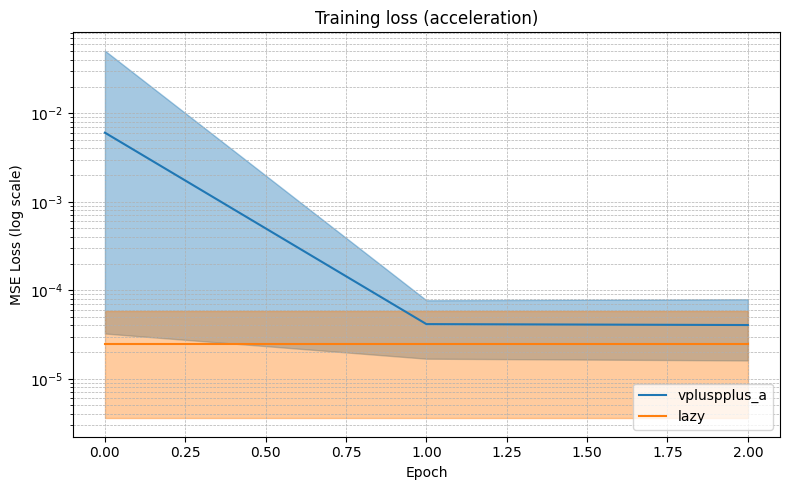

In [10]:
loss_all = [models[m]["train_losses"] for m in ["vpluspplus_a"]]

loss_all.append(np.tile(models["lazy"]["train_losses"], (loss_all[0].shape[0], 1)))

plot_log_loss(
    loss_all, [m for m in models], alpha=0.05, title="Training loss (acceleration)"
)
plt.show()

# loss_all = [models[m]["train_losses"] for m in models]
# plot_log_loss(loss_all,[m for m in models],
#              alpha = 0.05,
#              title = "Training loss")

### MSE on position prediction

In [11]:
# TO DO: move this into a function
loss_mse_all = {}
for m in models:
    loss_m = []
    epoch_num = list(models[m]["debug_result"].keys())[-1]

    for file_id in models[m]["debug_result"][epoch_num].keys():

        actual = np.concatenate(
            models[m]["debug_result"][epoch_num][file_id]["actual"], axis=0
        )
        predicted = np.concatenate(
            models[m]["debug_result"][epoch_num][file_id]["predicted"], axis=0
        )

        loss = functional.mse_loss(
            torch.tensor(actual), torch.tensor(predicted)
        )  # + 0.1 * torch.sum(edge_weight)
        loss_m.append(loss)
    loss_mse_all[m] = loss_m

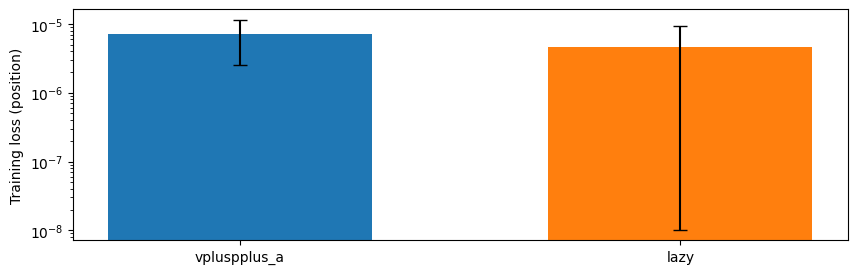

In [12]:
# plot all models
fig, ax = plt.subplots(figsize=(10, 3))

ind = 0
for m in models:
    name = m
    mean = np.mean(loss_mse_all[m])
    std_devs = 2 * np.std(loss_mse_all[m])
    ax.bar(ind, mean, width=0.6)
    ax.errorbar(ind, mean, yerr=std_devs, fmt="none", color="black", capsize=5)

    ind += 1
ax.set_xticks(np.arange(len(models)), labels=[m for m in models])
ax.set_ylabel("Training loss (position)")
plt.yscale("log", base=10)
plt.show()

### To investigate one model on one file

#### a) video, overlay trajectories on top of each other.

In [13]:
file_id = 2
m = "lazy"
epoch_num = 0
actual = np.concatenate(models[m]["debug_result"][epoch_num][file_id]["actual"], axis=0)
predicted_lazy = np.concatenate(
    models[m]["debug_result"][epoch_num][file_id]["predicted"], axis=0
)

actual_acc_lazy = np.concatenate(
    models[m]["debug_result"][epoch_num][file_id]["actual_acc"], axis=0
)
predicted_acc_lazy = np.concatenate(
    models[m]["debug_result"][epoch_num][file_id]["predicted_acc"], axis=0
)

loss_acc_lazy = np.array(models[m]["debug_result"][epoch_num][file_id]["loss"])

m = "vpluspplus_a"
epoch_num = 2

predicted_gnn = np.concatenate(
    models[m]["debug_result"][epoch_num][file_id]["predicted"], axis=0
)

actual_acc = np.concatenate(
    models[m]["debug_result"][epoch_num][file_id]["actual_acc"], axis=0
)
predicted_acc_gnn = np.concatenate(
    models[m]["debug_result"][epoch_num][file_id]["predicted_acc"], axis=0
)

loss_acc_gnn = np.array(models[m]["debug_result"][epoch_num][file_id]["loss"])

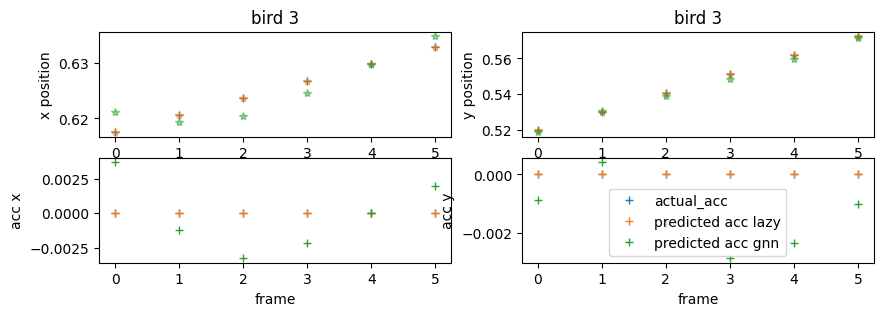

In [14]:
%matplotlib inline
b = 3
fig, ax = plt.subplots(2, 2, figsize=(10, 3))
ax = ax.ravel()

ax[0].plot(actual[:, b, 0], "+", label="actual")
ax[0].plot(predicted_lazy[:, b, 0], "*", label="predicted lazy", alpha=0.5)
ax[0].plot(predicted_gnn[:, b, 0], "*", label="predicted gnn", alpha=0.5)
ax[0].set_xlabel("frame")
ax[0].set_ylabel("x position")
ax[0].set_title("bird " + str(b))

ax[1].plot(actual[:, b, 1], "+", label="actual")
ax[1].plot(predicted_lazy[:, b, 1], "*", label="predicted lazy", alpha=0.5)
ax[1].plot(predicted_gnn[:, b, 1], "*", label="predicted gnn", alpha=0.5)
ax[1].set_xlabel("frame")
ax[1].set_ylabel("y position")
ax[1].set_title("bird " + str(b))

ax[2].plot(actual_acc[:, b, 0], "+", label="actual_acc")
ax[2].plot(predicted_acc_lazy[:, b, 0], "+", label="predicted acc lazy")
ax[2].plot(predicted_acc_gnn[:, b, 0], "+", label="predicted acc gnn")
# ax[2].plot(loss_acc, label="acc loss")
ax[2].set_xlabel("frame")
ax[2].set_ylabel("acc x")

ax[3].plot(actual_acc[:, b, 1], "+", label="actual_acc")
ax[3].plot(predicted_acc_lazy[:, b, 1], "+", label="predicted acc lazy")
ax[3].plot(predicted_acc_gnn[:, b, 1], "+", label="predicted acc gnn")
# ax[3].plot(loss_acc, label="acc loss")
ax[3].set_xlabel("frame")
ax[3].set_ylabel("acc y")

plt.legend()
plt.show()

#### b) visualize the dynamic weight matrices
Because the attention layer is a function 
$$
A: F \times F \rightarrow \mathbb{R},
$$
 where $F$ is the space of node feature, a subset of $\mathbb{R}^n$, n is the dimensionality of the input layer size, we obtain dynamic adjacency matrix as boids move around producing dynamic node features.

In [15]:
m = "vpluspplus_a"
W_output = models[m]["W_output"]

In [16]:
# choose a file
file_id = 3

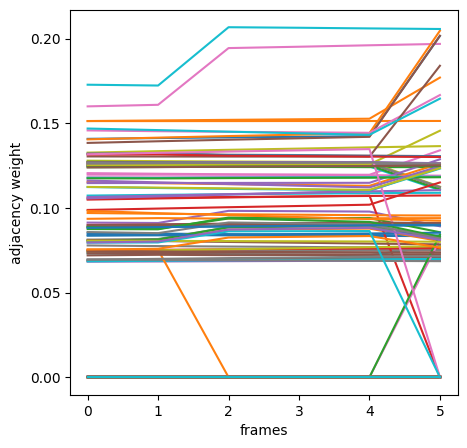

In [17]:
%matplotlib inline

final_epoch = list(W_output.keys())[-1]
W_output_overtime = W_output[final_epoch][file_id]
frames = np.arange(0, len(W_output_overtime))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
pairs = combinations(np.arange(np.shape(W_output_overtime[0])[0]), 2)
for p in pairs:
    W_output_overtime_ij = [W_output_overtime[t][p[0], p[1]] for t in frames]
    plt.plot(frames, W_output_overtime_ij)
plt.xlabel("frames")
plt.ylabel("adjacency weight")
plt.show()

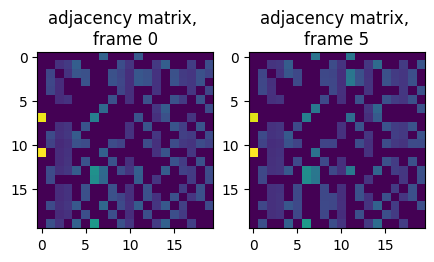

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(5, 5))
f0 = 0
f1 = len(W_output_overtime) - 1
ax[0].imshow(W_output_overtime[f0])
ax[0].set_title(f"adjacency matrix, \nframe {f0}")
ax[1].imshow(W_output_overtime[f1])
ax[1].set_title(f"adjacency matrix, \nframe {f1}")
plt.show()

## 4. Validate on held-out dataset

In [19]:
torch.cuda.empty_cache()

In [20]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
dataloader_list = list(test_loader)
visual_range = 0.5

/Users/dima/git/collab-environment/.venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [21]:
training = False
epoch_num = 1
lr = None

for m in models:

    (
        node_feature_function,
        node_prediction,
        input_differentiation,
        prediction_integration,
        in_node_dim,
        start_frame,
    ) = (
        models[m]["node_feature_function"],
        models[m]["node_prediction"],
        models[m]["input_differentiation"],
        models[m]["prediction_integration"],
        models[m]["in_node_dim"],
        models[m]["start_frame"],
    )

    gnn_model = models[m]["model"]

    # train models
    (models[m]["test_losses"], _, models[m]["test_debug_result"]) = train_rules_gnn(
        gnn_model,
        test_loader,
        visual_range=visual_range,
        epochs=epoch_num,
        lr=lr,
        training=training,
        species_dim=len(torch.unique(species)),
        device=None,
    )

    models[m]["test_W_input"], models[m]["test_W_output"] = get_adjcency_from_debug(
        models[m]["test_debug_result"], test_loader, visual_range
    )

/Users/dima/git/collab-environment/collab_env/gnn/gnn.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos = torch.tensor(pos)
/Users/dima/git/collab-environment/collab_env/gnn/gnn.py:357: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vel = torch.tensor(vel)
/Users/dima/git/collab-environment/collab_env/gnn/gnn.py:358: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  acc = torch.tensor(acc)
/Users/dima/git/collab-environment/collab_env/gnn/gnn.py:406: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

epoch 0


batch 0


batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


Epoch 000 | Train: 0.0001
finished one epoch
epoch 0


batch 0


batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


Epoch 000 | Train: 0.0000
finished one epoch


### Acceleration loss

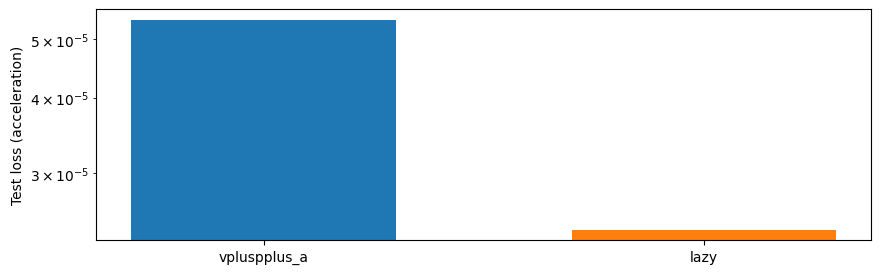

In [22]:
# plot all models
fig, ax = plt.subplots(figsize=(10, 3))

ind = 0
for m in models:
    name = m
    mean = np.mean(models[m]["test_losses"])
    std_devs = 2 * np.std(models[m]["test_losses"])
    ax.bar(ind, mean, width=0.6)
    # ax.errorbar(ind, mean, yerr=std_devs, fmt="none", color='black', capsize=5)

    ind += 1
ax.set_xticks(np.arange(len(models)), labels=[m for m in models])
ax.set_ylabel("Test loss (acceleration)")
plt.yscale("log", base=10)
plt.show()

### MSE position loss

In [23]:
test_loss_mse_all = {}
for m in models:
    loss_m = []
    epoch_num = list(models[m]["test_debug_result"].keys())[-1]

    for file_id in models[m]["test_debug_result"][epoch_num].keys():

        actual = np.concatenate(
            models[m]["test_debug_result"][epoch_num][file_id]["actual"], axis=0
        )
        predicted = np.concatenate(
            models[m]["test_debug_result"][epoch_num][file_id]["predicted"], axis=0
        )

        loss = functional.mse_loss(
            torch.tensor(actual), torch.tensor(predicted)
        )  # + 0.1 * torch.sum(edge_weight)
        loss_m.append(loss)
    test_loss_mse_all[m] = loss_m

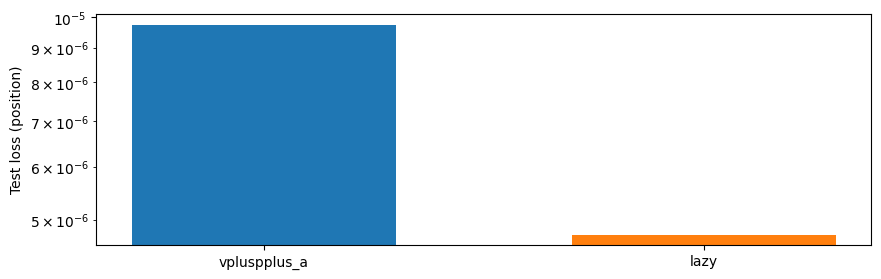

In [24]:
# plot all models
fig, ax = plt.subplots(figsize=(10, 3))

ind = 0
for m in models:
    name = m
    mean = np.mean(test_loss_mse_all[m])
    std_devs = 2 * np.std(test_loss_mse_all[m])
    ax.bar(ind, mean, width=0.6)
    # ax.errorbar(ind, mean, yerr=std_devs, fmt="none", color='black', capsize=5)

    ind += 1
ax.set_xticks(np.arange(len(models)), labels=[m for m in models])
ax.set_ylabel("Test loss (position)")
plt.yscale("log", base=10)
plt.show()